In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygame
import seaborn as sns
import random

# our classes
from agent import Agent, QLearningAgent
from environment import Environment
from screen import Screen

# setting random seed
random.seed(42)
np.random.seed(42)

pygame 2.0.0 (SDL 2.0.12, python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


Configurações gerais para a execução dos modelos:

* O espaço de ações é denifido como uma matrix identidade 3x3
* Há três ações possíveis (continuar na mesma direção, virar para a esquerda, virar para a direita)
* Como cada estado é representado por um vetor binário de 11 posições, ao todo há 2^11 estados possíveis

In [2]:
# define environment
ACTION_SPACE = np.eye(3)
NUM_ACTIONS = 3
NUM_STATES = 2 ** 11

In [3]:
# Set options to activate or deactivate the game view, and its speed
pygame.font.init()

In [4]:
def plot_metrics(metrics, filepath=None):
    formatted_dict = {'episodes': [],
                      'metrics': [],
                      'results': []}

    n = len(metrics['episodes'])
    for i in range(n):
        episode = metrics['episodes'][i]
        score = metrics['scores'][i]
        reward = metrics['rewards'][i]

        formatted_dict['episodes'].append(episode)
        formatted_dict['metrics'].append('score')
        formatted_dict['results'].append(score)

        formatted_dict['episodes'].append(episode)
        formatted_dict['metrics'].append('reward')
        formatted_dict['results'].append(reward)

    df_metrics = pd.DataFrame(formatted_dict)
    sns.lineplot(data=df_metrics, x='episodes', y='results', hue='metrics')
    if filepath is None:
        plt.show()
    else:
        plt.savefig(filepath)


def decode_state(encoded_state):
    """
    Decode a binary representation of a state into its decimal base;
    
    encoded_state: an array of 0s and 1s representing a binary value
    
    return: decimal value
    """
    decoded = ''
    for s in encoded_state:
        decoded += str(s)

    return int(decoded, 2)


def decode_action(encoded_action):
    if isinstance(encoded_action, np.ndarray):
        return encoded_action.argmax()
    return encoded_action


A função de recompensa padrão é definida como:
    
* Ganha 10 pontos por comer a maçã
* Perde 10 pontos por morrer
* Recompensa 0 caso contrário

In [5]:
def default_reward(env):
    """
    Return the reward.
    The reward is:
        -10 when Snake crashes.
        +10 when Snake eats food
        0 otherwise
    """
    reward = 0
    if env.game.crash:
        reward = -10
    elif env.player.eaten:
        reward = 10

    return reward

# Q-Learning

In [6]:
def run_q_learning(agent: Agent, reward_function, episodes, display, speed, verbose=True):
    if display:
        pygame.init()

    env = Environment(440, 440, reward_function)
    screen = Screen(env)

    episode = 0
    metrics = {'episodes': [],
               'scores': [],
               'rewards': []}

    while episode < episodes:
        if display:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    quit()
                    
            screen.display()

        state1, done = env.reset()
        state1 = decode_state(state1)
        action1 = agent.choose_action(state1)
        episode_reward = 0
        while not done:
            # Getting the next state, reward
            state2, reward, done = env.step(action1)
            state2 = decode_state(state2)
            # Choosing the next action
            action2 = agent.choose_action(state2)

            # Learning the Q-value
            decoded_action1 = decode_action(action1)
            decoded_action2 = decode_action(action2)
            agent.update(state1, state2, reward, decoded_action1, decoded_action2)

            state1 = state2
            action1 = action2
            episode_reward += reward

            if display:
                screen.display()
                pygame.time.wait(speed)

        episode += 1
        if verbose:
            print(f'Game {episode}      Score: {env.game.score}')

        mean_reward = episode_reward/episodes
        metrics['episodes'].append(episode)
        metrics['rewards'].append(mean_reward)
        metrics['scores'].append(env.game.score)

    return metrics

### Experimento 1:

* N0 = 1
* gamma = 1
* número de episódios = 150

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 0
Game 4      Score: 1
Game 5      Score: 1
Game 6      Score: 2
Game 7      Score: 1
Game 8      Score: 0
Game 9      Score: 1
Game 10      Score: 1
Game 11      Score: 1
Game 12      Score: 1
Game 13      Score: 1
Game 14      Score: 1
Game 15      Score: 1
Game 16      Score: 1
Game 17      Score: 1
Game 18      Score: 1
Game 19      Score: 1
Game 20      Score: 2
Game 21      Score: 3
Game 22      Score: 2
Game 23      Score: 3
Game 24      Score: 2
Game 25      Score: 2
Game 26      Score: 2
Game 27      Score: 1
Game 28      Score: 1
Game 29      Score: 2
Game 30      Score: 2
Game 31      Score: 1
Game 32      Score: 1
Game 33      Score: 3
Game 34      Score: 3
Game 35      Score: 3
Game 36      Score: 4
Game 37      Score: 1
Game 38      Score: 3
Game 39      Score: 5
Game 40      Score: 9
Game 41      Score: 5
Game 42      Score: 2
Game 43      Score: 2
Game 44      Score: 1
Game 45      Score: 3
Game 46      Score:

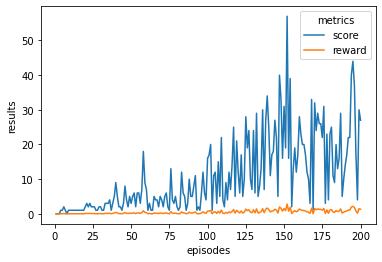

Run time: 74.74874758720398 seconds
Max. Score: 57


In [7]:
N0 = 1
gamma = 1

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=default_reward, episodes=200, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))

In [ ]:
N0 = 1

results = {'Gamma':[],
          'Run Time':[],
          'Max Score':[]}
for gamma in np.arange(0.8, 1.01, 0.01):
    print('Gamma', gamma)
    # define agent
    qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

    start = time.time()
    metrics = run_q_learning(qLearningAgent, reward_function=default_reward, episodes=150, speed=0, 
                             display=False, verbose=False)
    end = time.time()
  
    results['Gamma'].append(gamma)
    results['Run Time'].append(end-start)
    results['Max Score'].append(max(metrics['scores']))

Gamma 0.8
Gamma 0.81
Gamma 0.8200000000000001
Gamma 0.8300000000000001
Gamma 0.8400000000000001
Gamma 0.8500000000000001
Gamma 0.8600000000000001


In [ ]:
n = len(results['Gamma'])
for i in range(n):
    gamma = results['Gamma'][i]
    runtime = results['Run Time'][i]
    max_score = results['Max Score'][i]

    formatted_dict['Gamma'].append(gamma)
    formatted_dict['metrics'].append('Run Time')
    formatted_dict['results'].append(runtime)

    formatted_dict['Gamma'].append(gamma)
    formatted_dict['metrics'].append('Max Score')
    formatted_dict['results'].append(max_score)

df_metrics = pd.DataFrame(formatted_dict)
sns.lineplot(data=df_metrics, x='Gamma', y='results', hue='metrics')

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 2
Game 4      Score: 1
Game 5      Score: 1
Game 6      Score: 1
Game 7      Score: 2
Game 8      Score: 0
Game 9      Score: 1
Game 10      Score: 0
Game 11      Score: 1
Game 12      Score: 1
Game 13      Score: 1
Game 14      Score: 2
Game 15      Score: 2
Game 16      Score: 1
Game 17      Score: 1
Game 18      Score: 1
Game 19      Score: 1
Game 20      Score: 1
Game 21      Score: 1
Game 22      Score: 1
Game 23      Score: 1
Game 24      Score: 2
Game 25      Score: 1
Game 26      Score: 1
Game 27      Score: 1
Game 28      Score: 1
Game 29      Score: 5
Game 30      Score: 2
Game 31      Score: 3
Game 32      Score: 3
Game 33      Score: 1
Game 34      Score: 2
Game 35      Score: 6
Game 36      Score: 3
Game 37      Score: 3
Game 38      Score: 3
Game 39      Score: 2
Game 40      Score: 1
Game 41      Score: 4
Game 42      Score: 3
Game 43      Score: 2
Game 44      Score: 4
Game 45      Score: 2
Game 46      Score:

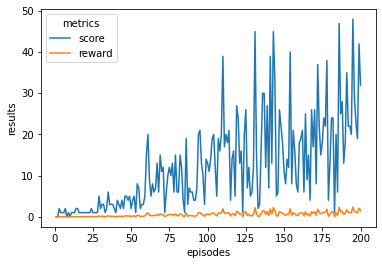

Run time: 4.728764295578003 seconds
Max. Score: 48


In [10]:
N0 = 1
gamma = 0.95

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=default_reward, episodes=200, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))